# Filters for Speckle Reduction
I have chosen the following four algorithms for speckle reduction. While all of these have their pros and cons, and more advanced techniques are available in literature, I felt these four algorithms best suit my coding capabilities. I have picked the most cited papers among the ones I found suitable for implementation.

- Adaptive Weighted Median Filter (AWMF)
- Directional Median Filter (DMF)
- Aggressive Region Growing Filter (ARGF)
- Geometric Filter (GF)

The detailed descriptions are given in the attached PDF.

In [1]:
from IP import *
import IP
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import skimage
from skimage.util import random_noise
from skimage.filters import median
%matplotlib inline
from scipy.io import loadmat

# Preprocessing
To make the runtimes feasible for testing purposes, I have chosen to resize the raw images to a dimension of 128x128 pixels.

In [2]:
figA1 = loadmat('FigA1.mat')
figB1 = loadmat('FigB1.mat')
data1 = loadmat('data1.mat')
data2 = loadmat('data2.mat')
data3 = loadmat('data3.mat')

In [4]:
# resizing
figA1_resized = imresize(figA1['image'],(128,128),anti_aliasing=True)
figB1_resized = imresize(figB1['image'],(128,128),anti_aliasing=True)
data1_resized = imresize(data1['image'],(128,128),anti_aliasing=True)
data2_resized = imresize(data2['image'],(128,128),anti_aliasing=True)
data3_resized = imresize(data3['image'],(128,128),anti_aliasing=True)

# converting them to 0-255 uint8 images
figA1_resized= figA1_resized-figA1_resized.min()
figA1_resized= (figA1_resized/figA1_resized.max()*255).astype("int")
figB1_resized= figB1_resized-figB1_resized.min()
figB1_resized= (figB1_resized/figB1_resized.max()*255).astype("int")
data1_resized= data1_resized-data1_resized.min()
data1_resized= (data1_resized/data1_resized.max()*255).astype("int")
data2_resized= data2_resized-data2_resized.min()
data2_resized= (data2_resized/data2_resized.max()*255).astype("int")
data3_resized= data3_resized-data3_resized.min()
data3_resized= (data3_resized/data3_resized.max()*255).astype("int")

# Implementation of the Adaptive Weighted Median Filter (AWMF)

In [5]:
# this function creates a distance matrix where each entry holds the
# corresponding pixel location's Eucledian distance from the center pixel
def generate_d(w_len):
    dist_mat = np.zeros((w_len,w_len))
    padding_len = int(np.floor(w_len/2.))
    for i in range(w_len):
        for j in range(w_len):
            dist_mat[i,j]=\
            np.linalg.norm(np.array([i,j])\
                           -np.array([padding_len,padding_len]))
    return dist_mat

In [6]:
# calculate the weight coefficients according to Loupas et al. [1]
def generate_w(w0,c,d,sig2,miu):
    temp_w = w0-(c*d*sig2/miu)
    temp_w[temp_w<0]=0
    return temp_w.round()

In [7]:
# replicates each pixel under the window 'weight' number of times
# to update its prominence in median calculation
def weighted_values(values,weights):
    weighted_list = []
    for i in range(values.shape[0]):
        for j in range(values.shape[1]):
            weighted_list.extend([values[i,j]]*weights[i,j])
    return weighted_list

In [8]:
def AWMF(I,w_len,w0,c,plot_steps=False):
    if(plot_steps):
        IP.plt.figure(figsize=(12,4))
        IP.plt.subplot(1,2,1);IP.plt.title('Input Image')
        IP.imshow(I,cmap='gray')
        print("Shape of input image:"+str(I.shape))
    
    if(w_len % 2 == 0):
        print("Please insert an odd kernel window length.")
        return
    
    #compute number of layers to pad
    padding_len = int(np.floor(w_len/2.))
    
    #initialize padded image with all zeros
    padded_I = np.zeros((I.shape[0]+2*padding_len,I.shape[1]+2*padding_len))
    
    # assign main image to the middle of the padded_image
    padded_I[padding_len:-padding_len,padding_len:-padding_len]=I
    
    #nearest neighbor assignments to the horizontal and vertical padded segments
    padded_I[0:padding_len,padding_len:-padding_len] = I[0,:]
    padded_I[-padding_len:,padding_len:-padding_len] = I[-1,:]
    padded_I[padding_len:-padding_len,0:padding_len] = I[:,0:1]
    padded_I[padding_len:-padding_len,-padding_len:] = I[:,-1:]
    
    #taking care of the four square corners of the padded layers
    padded_I[0:padding_len,0:padding_len] = \
    np.repeat(I[0,0], padding_len*padding_len).reshape(padding_len,padding_len)
    
    padded_I[-padding_len:,0:padding_len] = \
    np.repeat(I[-1,0], padding_len*padding_len).reshape(padding_len,padding_len)
    
    padded_I[0:padding_len:,-padding_len:] = \
    np.repeat(I[0,-1], padding_len*padding_len).reshape(padding_len,padding_len)
    
    padded_I[-padding_len:,-padding_len:] = \
    np.repeat(I[-1,-1], padding_len*padding_len).reshape(padding_len,padding_len)
    
    #initialize filtered image with all zeros
    filtered_I = np.zeros(I.shape)
    
    # compute distance matrix
    distance_mat = generate_d(w_len=w_len)
    
    #scan padded image with a kernel window of w_len*w_len dimension
    for id_r,row in enumerate(range(padding_len,padded_I.shape[0]-padding_len)):
        for id_c,col in enumerate(range(padding_len,padded_I.shape[1]-padding_len)):
            #grab values within kernel window and take median
            values = padded_I[row-padding_len:row+padding_len+1,\
                              col-padding_len:col+padding_len+1]
            
            # adaptively generate each pixel value's weight
            weights = generate_w(w0,c,distance_mat,\
                                 sig2=np.var(values),miu=np.mean(values))
            
            # replicate pixels according to weights
            weighted_values_list = weighted_values(values.astype("int"),\
                                                   weights.astype("int"))
          
            #assign median to filtered image
            filtered_I[id_r,id_c] = np.median(weighted_values_list)
    
    if(plot_steps):
        IP.plt.subplot(1,2,2);
        IP.imshow(filtered_I,cmap='gray');IP.plt.title('AWMF Filtered Image')
        print("Shape of filtered image:"+str(filtered_I.shape))
    return filtered_I

# Implementation of the Directional Median Filter (DMF)

In [9]:
def generate_sticks(w_len):
    padding_len = int(np.floor(w_len/2.))
    
    # horizontal stick
    a = np.zeros((w_len,w_len), int)
    a[padding_len,:]=1
    
    # diagonal stick
    d = np.zeros((w_len,w_len), int)
    np.fill_diagonal(d,1)
    
    # the other diagonal stick
    b=np.flip(d,axis=1)
    
    # vertical stick
    c = np.zeros((w_len,w_len), int)
    c[:,padding_len]=1
    
    return a,b,c,d

In [10]:
def DMF(I,w_len,plot_steps=False):
    if(plot_steps):
        IP.plt.figure(figsize=(12,4))
        IP.plt.subplot(1,2,1);IP.plt.title('Input Image')
        IP.imshow(I,cmap='gray')
        print("Shape of input image:"+str(I.shape))
    
    if(w_len % 2 == 0):
        print("Please insert an odd kernel window length.")
        return
    
    #compute number of layers to pad
    padding_len = int(np.floor(w_len/2.))
    
    #initialize padded image with all zeros
    padded_I = np.zeros((I.shape[0]+2*padding_len,I.shape[1]+2*padding_len))
    
    # assign main image to the middle of the padded_image
    padded_I[padding_len:-padding_len,padding_len:-padding_len]=I
    
    #nearest neighbor assignments to the horizontal and vertical padded segments
    padded_I[0:padding_len,padding_len:-padding_len] = I[0,:]
    padded_I[-padding_len:,padding_len:-padding_len] = I[-1,:]
    padded_I[padding_len:-padding_len,0:padding_len] = I[:,0:1]
    padded_I[padding_len:-padding_len,-padding_len:] = I[:,-1:]
    
    #taking care of the four square corners of the padded layers
    padded_I[0:padding_len,0:padding_len] = \
    np.repeat(I[0,0], padding_len*padding_len).reshape(padding_len,padding_len)
    
    padded_I[-padding_len:,0:padding_len] = \
    np.repeat(I[-1,0], padding_len*padding_len).reshape(padding_len,padding_len)
    
    padded_I[0:padding_len:,-padding_len:] = \
    np.repeat(I[0,-1], padding_len*padding_len).reshape(padding_len,padding_len)
    
    padded_I[-padding_len:,-padding_len:] = \
    np.repeat(I[-1,-1], padding_len*padding_len).reshape(padding_len,padding_len)
    
    # initialize filtered image with all zeros
    filtered_I = np.zeros(I.shape)
    
    # get the four sticks
    a,b,c,d = generate_sticks(w_len) 
    
    #scan padded image with a kernel window of w_len*w_len dimension
    for id_r,row in enumerate(range(padding_len,padded_I.shape[0]-padding_len)):
        for id_c,col in enumerate(range(padding_len,padded_I.shape[1]-padding_len)):
            #grab values within kernel window and take median
            values = padded_I[row-padding_len:row+padding_len+1,\
                              col-padding_len:col+padding_len+1].astype("int")
            
            # consider the values lying along the sticks
            stick_a = values[values*a>0]
            stick_b = values[values*b>0]
            stick_c = values[values*c>0]
            stick_d = values[values*d>0]
            
            # compute median along each stick orientation
            median_list = [np.median(stick_a),\
                           np.median(stick_b),np.median(stick_c),\
                           np.median(stick_d)]
          
            #assign max median to filtered image
            filtered_I[id_r,id_c] = max(median_list)
    
    if(plot_steps):
        IP.plt.subplot(1,2,2);
        IP.imshow(filtered_I,cmap='gray')
        IP.plt.title('Directional Median Filtered Image')
        print("Shape of filtered image:"+str(filtered_I.shape))
    return filtered_I

# Implementation of the Aggressive Region Growing Filter (ARGF)

In [11]:
def ARGF(I,w_len,a=2.,b=19.5,c=0.3,d=0.004,k=0.5,S_min=49,plot_steps=False):
    if(plot_steps):
        IP.plt.figure(figsize=(18,4))
        IP.plt.subplot(1,3,1);IP.plt.title('Input Image')
        IP.imshow(I,cmap='gray')
        print("Shape of input image:"+str(I.shape))
    
    if(w_len % 2 == 0):
        print("Please insert an odd kernel window length.")
        return
    
    #compute number of layers to pad
    padding_len = int(np.floor(w_len/2.))
    
    #initialize padded image with all zeros
    padded_I = np.zeros((I.shape[0]+2*padding_len,I.shape[1]+2*padding_len))
    
    # assign main image to the middle of the padded_image
    padded_I[padding_len:-padding_len,padding_len:-padding_len]=I
    
    #nearest neighbor assignments to the horizontal and vertical padded segments
    padded_I[0:padding_len,padding_len:-padding_len] = I[0,:]
    padded_I[-padding_len:,padding_len:-padding_len] = I[-1,:]
    padded_I[padding_len:-padding_len,0:padding_len] = I[:,0:1]
    padded_I[padding_len:-padding_len,-padding_len:] = I[:,-1:]
    
    #taking care of the four square corners of the padded layers
    padded_I[0:padding_len,0:padding_len] = \
    np.repeat(I[0,0], padding_len*padding_len).reshape(padding_len,padding_len)
    
    padded_I[-padding_len:,0:padding_len] = \
    np.repeat(I[-1,0], padding_len*padding_len).reshape(padding_len,padding_len)
    
    padded_I[0:padding_len:,-padding_len:] = \
    np.repeat(I[0,-1], padding_len*padding_len).reshape(padding_len,padding_len)
    
    padded_I[-padding_len:,-padding_len:] = \
    np.repeat(I[-1,-1], padding_len*padding_len).reshape(padding_len,padding_len)

    if(plot_steps):
        IP.plt.subplot(1,3,2);
        IP.imshow(padded_I,cmap='gray');IP.plt.title('Padded Image')
        print("Shape of padded image:"+str(padded_I.shape))
    
    #initialize filtered image with all zeros
    filtered_I = np.zeros(I.shape) 
    
    #scan padded image with a kernel window of w_len*w_len dimension
    for id_r,row in enumerate(range(padding_len,padded_I.shape[0]-padding_len)):
        for id_c,col in enumerate(range(padding_len,padded_I.shape[1]-padding_len)):
            # grab values within kernel window and take median
            values = padded_I[row-padding_len:row+padding_len+1,\
                              col-padding_len:col+padding_len+1]
            
            # region contraction phase
            hij = np.var(values)/np.mean(values)
            h0wd = (a*values.size)/(b+values.size)
            sig0wd = c+k*np.exp(-1*d*(values.size))
            temp_len = padding_len
            
            # keep contracting until condition is violated
            while(hij>(h0wd+sig0wd) and values.size>S_min):
                temp_len = temp_len-1
                values = padded_I[row-temp_len:row+temp_len+1,\
                                  col-temp_len:col+temp_len+1]
                hij = np.var(values)/np.mean(values)
                h0wd = (a*values.size)/(b+values.size)
                sig0wd = c+k*np.exp(-1*d*(values.size))

            # region growth phase
            hij = np.var(values)/np.mean(values)
            h0wd = (a*values.size)/(b+values.size)
            sig0wd = c+k*np.exp(-1*d*(values.size))
            hij_old = hij
            temp_len2 = temp_len
            
            # keep growing until condition is violated
            while(hij<=(h0wd+sig0wd) and values.size<w_len**2 \
                  and np.abs(hij-hij_old)<sig0wd):
                hij_old = hij
                temp_len2 = temp_len2+1
                values = padded_I[row-temp_len2:row+temp_len2+1,\
                                  col-temp_len2:col+temp_len2+1]
                hij = np.var(values)/np.mean(values)
                h0wd = (a*values.size)/(b+values.size)
                sig0wd = c+k*np.exp(-1*d*(values.size))
          
            #assign mean or median to filtered image
            if(values.size > w_len**2):
                filtered_I[id_r,id_c] = np.mean(values)
            else:
                filtered_I[id_r,id_c] = np.median(values)
    
    if(plot_steps):
        IP.plt.subplot(1,3,3);
        IP.imshow(filtered_I,cmap='gray');IP.plt.title('Filtered Image')
        print("Shape of filtered image:"+str(filtered_I.shape))
    return filtered_I

# Implementation of the Geometric Filter (GF)

In [12]:
# this function checks if a 0 should be converted into a 1 according
# to the 8-hull template patterns

def check_hull8_pattern(block,mode='all'):
    pattern1 = np.array([[1,0,0],[1,0,0],[1,1,0]])
    pattern2 = np.array([[0,0,0],[1,0,0],[1,1,1]])
    pattern3 = np.array([[0,0,0],[0,0,1],[1,1,1]])
    pattern4 = np.array([[0,0,1],[0,0,1],[0,1,1]])
    patterns_a = [pattern1,pattern2,pattern3,pattern4]
    
    if(mode=='a'):
        for pattern in patterns_a:
            block_temp = block*pattern
            if(np.array_equal(block_temp, pattern)):
                # found match!
                return True
               
    pattern5 = np.array([[1,1,0],[1,0,0],[1,0,0]])
    pattern6 = np.array([[1,1,1],[1,0,0],[0,0,0]])
    pattern7 = np.array([[1,1,1],[0,0,1],[0,0,0]])
    pattern8 = np.array([[0,1,1],[0,0,1],[0,0,1]])
    patterns_b = [pattern5,pattern6,pattern7,pattern8]
    
    if(mode=='b'):
        for pattern in patterns_b:
            block_temp = block*pattern
            if(np.array_equal(block_temp, pattern)):
                # found match!
                return True
    
    patterns_all = patterns_a+patterns_b
    
    if(mode=='all'):
        for pattern in patterns_all:
            block_temp = block*pattern
            if(np.array_equal(block_temp, pattern)):
                # found match!
                return True
    
    # no match found 
    return False

In [13]:
# implements 8-hull algorithm

def hull8(I,mode='all'):
    output = np.zeros((I.shape))
    output[0:1,:] = I[0,:]
    output[-1:,:] = I[-1,:]
    output[:,0:1] = I[:,0:1]
    output[:,-1:] = I[:,-1:]
    for row in range(1,I.shape[0]-1):
        for col in range(1,I.shape[1]-1):
            # if center pixel is already 1, we don't care
            if(I[row,col] == 0): 
                neighborhood_block = I[row-1:row+2,col-1:col+2]
                if (check_hull8_pattern(neighborhood_block,mode)):
                    output[row,col] = 1
            else:
                output[row,col] = 1
    return output

In [14]:
# converts 0's to 1's and vice versa. 
# Wonder if there was a better way though.

def complement_mat(i):
    return 1*(i<0.5)

In [15]:
# implements the complimentary hull algorithm
def complimentary_hull(I):
    I1 = hull8(I,'a')
    I1 = complement_mat(I1)
    I1 = hull8(I1,'b')
    I1 = complement_mat(I1)
    return I1

In [16]:
# from a line of pixels, generates a vertical pixel grid
def pixelrow2vertgrid(pixel_row):
    vertical_grid = np.zeros((256,len(pixel_row)),int)
    for idx,intensity in enumerate(pixel_row):
        vertical_grid[255-intensity:,idx] = 1
    return vertical_grid

In [17]:
# from a vertical pixel grid, goes back to line of pixels
def vertgrid2pixelrow(vertical_grid):
    return np.sum(vertical_grid,axis=0)-1

In [25]:
def GF(I):
    #E-W direction
    print('GF step: Beginning E-W direction')
    temp=np.zeros(I.shape,int)
    for row in range(I.shape[0]):
        # generate vertical pixel grid
        vertical_grid=pixelrow2vertgrid(list(I[row,:].\
                                             astype("int")))
        
        # run complimentary hull algorithm on the grid
        comp_output = complimentary_hull(vertical_grid)
        
        # convert updated grid back to a line of pixels
        updated_row = vertgrid2pixelrow(comp_output)
        
        # save the row
        temp[row,:] = updated_row
    
    #N-S direction
    print('GF step: Beginning N-S direction')
    temp2=np.zeros(I.shape,int)
    for col in range(I.shape[1]):
        # same as before
        vertical_grid=pixelrow2vertgrid(list(temp[:,col].\
                                             astype("int")))
        comp_output = complimentary_hull(vertical_grid)
        updated_row = vertgrid2pixelrow(comp_output)
        temp2[:,col] = updated_row  
    
    # SE-NW direction
    print('GF step: Beginning SE-NW direction')
    diags1 = [temp2.diagonal(i) for i in range(temp2.shape[1]-1,\
                                               -temp2.shape[0],-1)]
    
    temp3=np.zeros(I.shape,int)
    for idx, diag in enumerate(diags1):
        # same as before
        vertical_grid=pixelrow2vertgrid(list(np.round(diag).\
                                             astype("int")))
        comp_output = complimentary_hull(vertical_grid)
        updated_row = vertgrid2pixelrow(comp_output)
        if(idx<I.shape[0]):
            i = I.shape[0]-1-idx
            np.fill_diagonal(temp3[:,i:], updated_row)
        else:
            i = idx + 1-I.shape[0]
            np.fill_diagonal(temp3[i:], updated_row)

    # SW-NE direction
    print('GF step: Beginning SW-NE direction')
    diags2 = [temp3[::-1,:].diagonal(i) for i in \
              range(-temp3.shape[0]+1,temp3.shape[1])]
    
    temp4=np.zeros(I.shape,int)
    for idx, diag in enumerate(diags2):
        # same as before
        vertical_grid=pixelrow2vertgrid(list(np.round(diag).\
                                             astype("int")))
        comp_output = complimentary_hull(vertical_grid)
        updated_row = vertgrid2pixelrow(comp_output)
        row_opposite = updated_row[::-1]
        temp4=np.fliplr(temp4)
        if(idx<I.shape[0]):
            i = I.shape[0]-1-idx
            np.fill_diagonal(temp4[:,i:], row_opposite)
        else:
            i = idx + 1-I.shape[0]
            np.fill_diagonal(temp4[i:], row_opposite)
        temp4=np.fliplr(temp4)
    
    return temp4

# Output Comparison

In [26]:
image_list = [data1_resized, data2_resized, data3_resized] 
output_dict = {1:[], 2:[], 3:[]}

for idx, im in enumerate(image_list):
    print("Applying AWMF to data"+str(idx+1))
    data_AWMF = AWMF(im,w_len=9,w0=10,c=0.25,plot_steps=False)
    output_dict[idx+1].append(data_AWMF)
    
    print("Applying DMF to data"+str(idx+1))
    data_directional = DMF(im,w_len=9,plot_steps=False)
    output_dict[idx+1].append(data_directional)
    
    print("Applying ARGF to data"+str(idx+1))
    data_ARGF = ARGF(im,w_len=11,a=2.,b=19.5,c=0.3,\
                     d=0.004,k=0.5,S_min=49,plot_steps=False)
    output_dict[idx+1].append(data_ARGF)
    
    print("Applying GF to data"+str(idx+1))
    im_resized = imresize(im,(64,64),anti_aliasing=True)
    im_resized = im_resized-im_resized.min()
    im_resized = (im_resized/im_resized.max()*255).astype("int");
    data_geom = GF(im_resized)
    output_dict[idx+1].append(data_geom)

Applying AWMF to data1
Applying DMF to data1
Applying ARGF to data1
Applying GF to data1
GF step: Beginning E-W direction
GF step: Beginning N-S direction
GF step: Beginning SE-NW direction
GF step: Beginning SW-NE direction
Applying AWMF to data2
Applying DMF to data2
Applying ARGF to data2
Applying GF to data2
GF step: Beginning E-W direction
GF step: Beginning N-S direction
GF step: Beginning SE-NW direction
GF step: Beginning SW-NE direction
Applying AWMF to data3
Applying DMF to data3
Applying ARGF to data3
Applying GF to data3
GF step: Beginning E-W direction
GF step: Beginning N-S direction
GF step: Beginning SE-NW direction
GF step: Beginning SW-NE direction


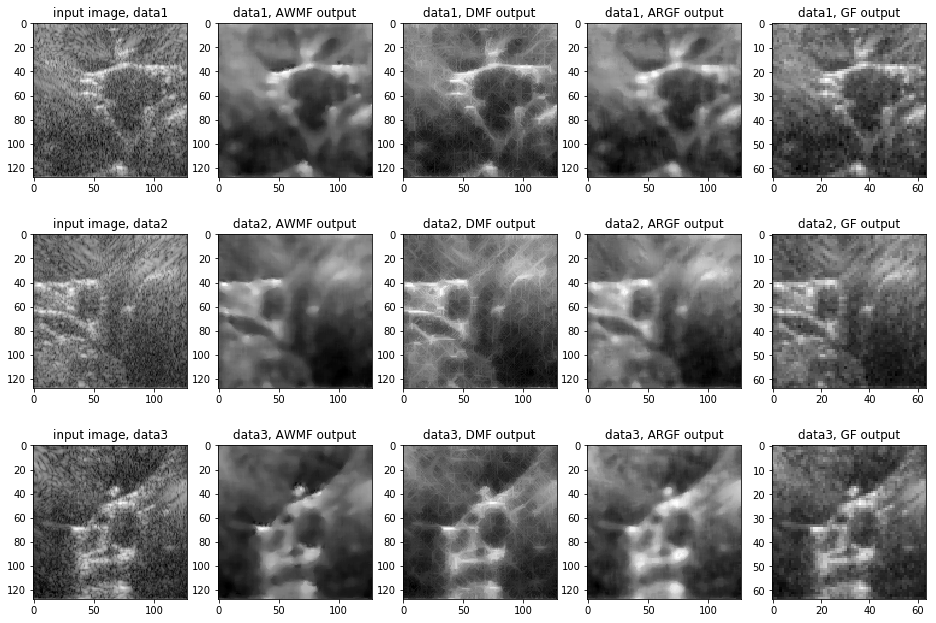

In [30]:
# plotting outputs
IP.plt.figure(figsize=(16,11))

for idx, im in enumerate(image_list):
    IP.plt.subplot(3,5,5*idx+1)
    IP.imshow(im,cmap='gray')
    IP.plt.title('input image, data'+str(idx+1))
    
    IP.plt.subplot(3,5,5*idx+2)
    IP.imshow(output_dict[idx+1][0],cmap='gray')
    IP.plt.title('data'+str(idx+1)+', AWMF output')
    
    IP.plt.subplot(3,5,5*idx+3)
    IP.imshow(output_dict[idx+1][1],cmap='gray')
    IP.plt.title('data'+str(idx+1)+', DMF output')
    
    IP.plt.subplot(3,5,5*idx+4)
    IP.imshow(output_dict[idx+1][2],cmap='gray')
    IP.plt.title('data'+str(idx+1)+', ARGF output')

    IP.plt.subplot(3,5,5*idx+5)
    IP.imshow(output_dict[idx+1][3],cmap='gray')
    IP.plt.title('data'+str(idx+1)+', GF output')